# Multiclass image classsification with ResNet18 in PyTorch

This notebook was created as part of participating in Coursera's [Detecting COVID-19 with Chest X-Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) project.

It presents the implementation of a multiclass image classification model developed by fine tuning a ResNet18 base model pre-trained on ImageNet. The fine-tuning is done using the data from the [COVID-19 Radiography Database](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database/), essentially producing a model that establishes whether a chest X-ray features a COVID-19 infection, viral pneumonia, or normal lungs).

Side note: The model achieves 96% accuracy after a single training epoch. However, testing with data from a local source, I've found that the new data often gets misclassified as COVID-19. My best guess is that this is due to the fact that in this dataset normal lungs seem to have sharper bone contrast as opposed to other categories, and the images I have used also feature lesser bone contrast.

## Imports

In [1]:
%matplotlib inline
import os, shutil, random, torch, torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(1)
print('Using PyTorch version', torch.__version__)

# certificate issue workaround (this is a specific issue with a goverment ID software I have on my PC)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Using PyTorch version 1.6.0


## Training/test split

In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

# check if the data needs preprocessing
if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))
    
    # rename data directories to match class names
    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))
    
    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))
        
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        # create the test set
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

## Dataset class

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
    
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        # randomly select one of the classes
        class_name = random.choice(self.class_names)
        # avoid out-of-bounds index value
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        # convert to RGB to match pre-trained weights of the ResNet
        image = Image.open(image_path).convert('RGB')
        # transform PILL image to tensor
        return self.transform(image), self.class_names.index(class_name)

## Image transformations (augmentation)

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # values from ImageNet
])

In [5]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # values from ImageNet
])

## Data loaders

In [6]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [7]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [8]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f'Num of training batches {len(dl_train)}')
print(f'Num of test batches {len(dl_test)}')

Num of training batches 470
Num of test batches 15


## Data visualization

In [9]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    
    for i, image in enumerate(images):
        # batch per row
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        # image to ndarray and transpose (because implementation is channel-first and matplotlib expects channel-last)
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    
    plt.tight_layout()
    plt.show()

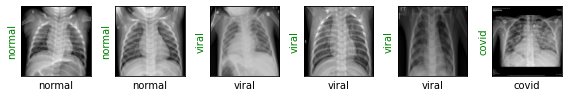

In [10]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

## Creating the model

In [11]:
# base model
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# fine tuning the last fully connected layer
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

## Training the model

In [15]:
def train(epochs):
    print('Starting training...')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet18.train()
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            # gradient step (backpropagation)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                acc = 0.
                val_loss = 0.
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)
                acc = acc / len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                
                resnet18.train()
                if acc > 0.95:
                    print('Performance condition satisfied.')
                    return
            
            train_loss /= (train_step + 1)
            print(f'Training loss: {train_loss:.4f}')

Starting training...
Starting epoch 1/1
Evaluating at step 0
Val loss: 1.4638, Acc: 0.3333


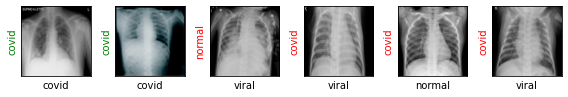

Training loss: 1.0227
Training loss: 1.0711
Training loss: 0.6727
Training loss: 0.3834
Training loss: 0.2711
Training loss: 0.2172
Training loss: 0.1697
Training loss: 0.1006
Training loss: 0.0607
Training loss: 0.0838
Training loss: 0.0959
Training loss: 0.0576
Training loss: 0.0842
Training loss: 0.0502
Training loss: 0.0618
Training loss: 0.0405
Training loss: 0.0330
Training loss: 0.0530
Training loss: 0.0434
Training loss: 0.0436
Evaluating at step 20
Val loss: 0.6722, Acc: 0.6778


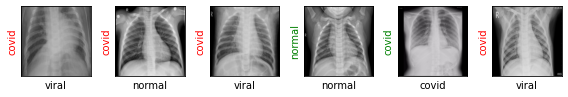

Training loss: 0.0274
Training loss: 0.0163
Training loss: 0.0581
Training loss: 0.0200
Training loss: 0.0294
Training loss: 0.0527
Training loss: 0.0151
Training loss: 0.0071
Training loss: 0.0091
Training loss: 0.0110
Training loss: 0.0157
Training loss: 0.0150
Training loss: 0.0075
Training loss: 0.0173
Training loss: 0.0071
Training loss: 0.0092
Training loss: 0.0137
Training loss: 0.0057
Training loss: 0.0080
Training loss: 0.0053
Evaluating at step 40
Val loss: 0.2675, Acc: 0.9333


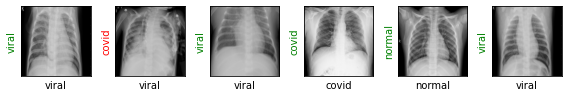

Training loss: 0.0237
Training loss: 0.0177
Training loss: 0.0046
Training loss: 0.0049
Training loss: 0.0200
Training loss: 0.0060
Training loss: 0.0041
Training loss: 0.0051
Training loss: 0.0025
Training loss: 0.0083
Training loss: 0.0070
Training loss: 0.0035
Training loss: 0.0018
Training loss: 0.0052
Training loss: 0.0038
Training loss: 0.0013
Training loss: 0.0020
Training loss: 0.0023
Training loss: 0.0077
Training loss: 0.0033
Evaluating at step 60
Val loss: 0.1106, Acc: 0.9778


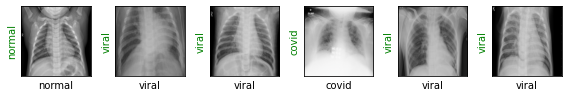

Performance condition satisfied.


In [16]:
train(epochs=1)

## Predictions

In [17]:
def show_preds():
    # set the model to evaluation mode
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

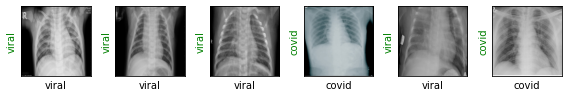

In [18]:
show_preds()